In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import  SpectralClustering, AgglomerativeClustering
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA

import seaborn as sns


import random
random.seed(10)

In [2]:
import warnings
 
# Ignore the specific FutureWarning
warnings.filterwarnings(action='ignore', category=FutureWarning, module='pandas')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='sklearn')


# 0. Helper Functions

In [3]:
#########################################################################################################
#########################################################################################################
### Implementation by Edwin Chen (https://github.com/echen/restricted-boltzmann-machines/tree/master) ###
#########################################################################################################
#########################################################################################################

from __future__ import print_function

class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.debug_print = True

        # Initialize a weight matrix, of dimensions (num_visible x num_hidden), using
        # a uniform distribution between -sqrt(6. / (num_hidden + num_visible))
        # and sqrt(6. / (num_hidden + num_visible)). One could vary the 
        # standard deviation by multiplying the interval with appropriate value.
        # Here we initialize the weights with mean 0 and standard deviation 0.1. 
        # Reference: Understanding the difficulty of training deep feedforward 
        # neural networks by Xavier Glorot and Yoshua Bengio
        np_rng = np.random.RandomState(1234)

        self.weights = np.asarray(np_rng.uniform(
                low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                            high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                            size=(num_visible, num_hidden)))


        # Insert weights for the bias units into the first row and first column.
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)

    def train(self, data, max_epochs = 1000, learning_rate = 0.1):
        """
        Train the machine.

        Parameters
        ----------
        data: A matrix where each row is a training example consisting of the states of visible units.    
        """

        num_examples = data.shape[0]

        # Insert bias units of 1 into the first column.
        data = np.insert(data, 0, 1, axis = 1)

        for epoch in range(max_epochs):      
          # Clamp to the data and sample from the hidden units. 
          # (This is the "positive CD phase", aka the reality phase.)
          pos_hidden_activations = np.dot(data, self.weights)      
          pos_hidden_probs = self._logistic(pos_hidden_activations)
          pos_hidden_probs[:,0] = 1 # Fix the bias unit.
          pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
          # Note that we're using the activation *probabilities* of the hidden states, not the hidden states       
          # themselves, when computing associations. We could also use the states; see section 3 of Hinton's 
          # "A Practical Guide to Training Restricted Boltzmann Machines" for more.
          pos_associations = np.dot(data.T, pos_hidden_probs)

          # Reconstruct the visible units and sample again from the hidden units.
          # (This is the "negative CD phase", aka the daydreaming phase.)
          neg_visible_activations = np.dot(pos_hidden_states, self.weights.T)
          neg_visible_probs = self._logistic(neg_visible_activations)
          neg_visible_probs[:,0] = 1 # Fix the bias unit.
          neg_hidden_activations = np.dot(neg_visible_probs, self.weights)
          neg_hidden_probs = self._logistic(neg_hidden_activations)
          # Note, again, that we're using the activation *probabilities* when computing associations, not the states 
          # themselves.
          neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

          # Update weights.
          self.weights += learning_rate * ((pos_associations - neg_associations) / num_examples)

          error = np.sum((data - neg_visible_probs) ** 2)
          if self.debug_print:
            print("Epoch %s: error is %s" % (epoch, error))
        return error
            
    def run_visible(self, data):
        """
        Assuming the RBM has been trained (so that weights for the network have been learned),
        run the network on a set of visible units, to get a sample of the hidden units.

        Parameters
        ----------
        data: A matrix where each row consists of the states of the visible units.

        Returns
        -------
        hidden_states: A matrix where each row consists of the hidden units activated from the visible
        units in the data matrix passed in.
        """

        num_examples = data.shape[0]

        # Create a matrix, where each row is to be the hidden units (plus a bias unit)
        # sampled from a training example.
        hidden_states = np.ones((num_examples, self.num_hidden + 1))

        # Insert bias units of 1 into the first column of data.
        data = np.insert(data, 0, 1, axis = 1)

        # Calculate the activations of the hidden units.
        hidden_activations = np.dot(data, self.weights)
        # Calculate the probabilities of turning the hidden units on.
        hidden_probs = self._logistic(hidden_activations)
        # Turn the hidden units on with their specified probabilities.
        hidden_states[:,:] = hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
        # Always fix the bias unit to 1.
        # hidden_states[:,0] = 1

        # Ignore the bias units.
        hidden_states = hidden_states[:,1:]
        return hidden_states

      # TODO: Remove the code duplication between this method and `run_visible`?
    def run_hidden(self, data):
        """
        Assuming the RBM has been trained (so that weights for the network have been learned),
        run the network on a set of hidden units, to get a sample of the visible units.

        Parameters
        ----------
        data: A matrix where each row consists of the states of the hidden units.

        Returns
        -------
        visible_states: A matrix where each row consists of the visible units activated from the hidden
        units in the data matrix passed in.
        """

        num_examples = data.shape[0]

        # Create a matrix, where each row is to be the visible units (plus a bias unit)
        # sampled from a training example.
        visible_states = np.ones((num_examples, self.num_visible + 1))

        # Insert bias units of 1 into the first column of data.
        data = np.insert(data, 0, 1, axis = 1)

        # Calculate the activations of the visible units.
        visible_activations = np.dot(data, self.weights.T)
        # Calculate the probabilities of turning the visible units on.
        visible_probs = self._logistic(visible_activations)
        # Turn the visible units on with their specified probabilities.
        visible_states[:,:] = visible_probs > np.random.rand(num_examples, self.num_visible + 1)
        # Always fix the bias unit to 1.
        # visible_states[:,0] = 1

        # Ignore the bias units.
        visible_states = visible_states[:,1:]
        return visible_states

    def daydream(self, num_samples):
        """
        Randomly initialize the visible units once, and start running alternating Gibbs sampling steps
        (where each step consists of updating all the hidden units, and then updating all of the visible units),
        taking a sample of the visible units at each step.
        Note that we only initialize the network *once*, so these samples are correlated.

        Returns
        -------
        samples: A matrix, where each row is a sample of the visible units produced while the network was
        daydreaming.
        """

        # Create a matrix, where each row is to be a sample of of the visible units 
        # (with an extra bias unit), initialized to all ones.
        samples = np.ones((num_samples, self.num_visible + 1))

        # Take the first sample from a uniform distribution.
        samples[0,1:] = np.random.rand(self.num_visible)

        # Start the alternating Gibbs sampling.
        # Note that we keep the hidden units binary states, but leave the
        # visible units as real probabilities. See section 3 of Hinton's
        # "A Practical Guide to Training Restricted Boltzmann Machines"
        # for more on why.
        for i in range(1, num_samples):
          visible = samples[i-1,:]

          # Calculate the activations of the hidden units.
          hidden_activations = np.dot(visible, self.weights)      
          # Calculate the probabilities of turning the hidden units on.
          hidden_probs = self._logistic(hidden_activations)
          # Turn the hidden units on with their specified probabilities.
          hidden_states = hidden_probs > np.random.rand(self.num_hidden + 1)
          # Always fix the bias unit to 1.
          hidden_states[0] = 1

          # Recalculate the probabilities that the visible units are on.
          visible_activations = np.dot(hidden_states, self.weights.T)
          visible_probs = self._logistic(visible_activations)
          visible_states = visible_probs > np.random.rand(self.num_visible + 1)
          samples[i,:] = visible_states

        # Ignore the bias units (the first column), since they're always set to 1.
        return samples[:,1:]        
    def _logistic(self, x):
        return 1.0 / (1 + np.exp(-x))


# 1. Load Dataset

In [4]:
import pandas as pd  # Ensure that pandas is imported as it's used to handle dataframes

# Reading a csv file into a dataframe (df)
df = pd.read_csv("vec_med_no_route_features_1029.csv")

# Replacing boolean values, True and False, with integers 1 and 0 respectively in the dataframe
df = df.replace(True, 1)
df = df.replace(False, 0)

# Dataframe with features only
filter_col = ['Death_at_discharge',	'Delirium_ICU',	'AKI',	'total_length_days',
            'Mechanical_ventilation',	'dur_MV_days',	'admission_dx',	'first_MV',
            'firstMV_fac',	'vasopressor_ICU_day',	'PATIENT_DEID']

features_df = df[filter_col].copy()
c_med_data = df.iloc[:,:-15].copy()

In [5]:
c_med_data

,ACETAMINOPHEN,ACETAZOLAMIDE,ACETYLCYSTEINE,ACYCLOVIR,ADENOSINE,ALBUMIN,ALBUTEROL SULFATE,ALLOPURINOL,ALPRAZOLAM,ALTEPLASE,...,VENLAFAXINE,VERAPAMIL,VITAMIN A,VITAMIN B,VITAMIN D,VORICONAZOLE,WARFARIN,ZINC SULFATE,ZIPRASIDONE,ZOLPIDEM
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
987,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
988,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
989,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [6]:
zeros_num = (c_med_data == 0).sum().sum()
print('total sparsity: {}'.format(zeros_num))

num_meds_taken = c_med_data.sum(axis = 1)
num_meds_taken.describe()

total sparsity: 408581


count    991.000000
mean      27.708375
std       13.325101
min        3.000000
25%       19.000000
50%       25.000000
75%       35.000000
max      103.000000
dtype: float64

In [7]:
X = c_med_data.copy().transpose()
X

,0,1,2,3,4,5,6,7,8,9,...,981,982,983,984,985,986,987,988,989,990
ACETAMINOPHEN,1,0,1,1,1,1,1,0,1,1,...,1,1,0,1,1,1,0,1,0,0
ACETAZOLAMIDE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACETYLCYSTEINE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACYCLOVIR,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ADENOSINE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VORICONAZOLE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WARFARIN,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
ZINC SULFATE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZIPRASIDONE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Medication Clustering

## PCA

/var/folders/54/1zrdd3f502z54thfc2d33g580000gn/T/ipykernel_80786/3707900238.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([s if int(s.get_text())%25 == 0 else '' for s in ax.get_xticklabels()])


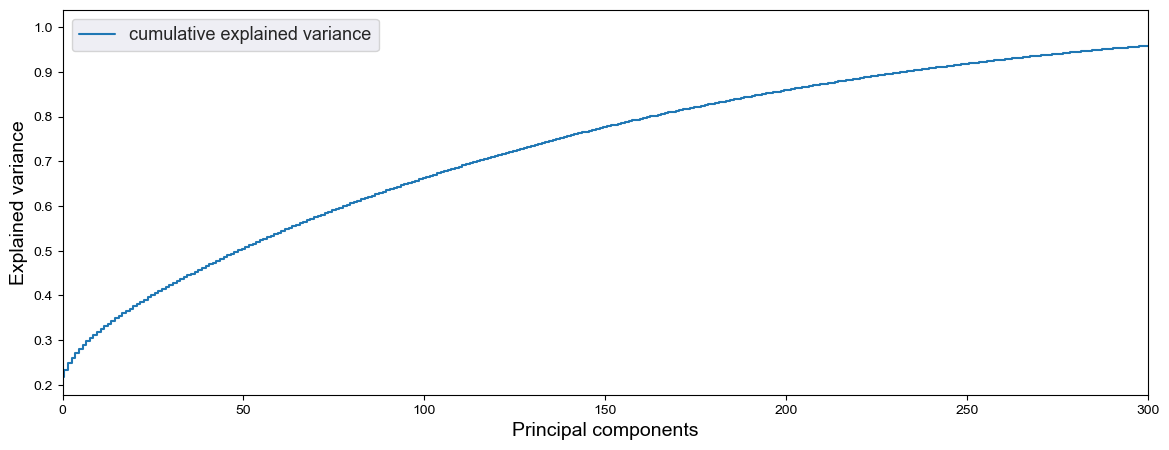

In [8]:
# Assuming X is your data
# Standardizing the features in your data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Normalizing the standardized data
X_normalized = normalize(X_scaled)

# Converting the normalized data back to a DataFrame
X_normalized = pd.DataFrame(X_normalized)

# Applying Principal Component Analysis (PCA)
pca = PCA()
X_principal = pca.fit(X_normalized)  # Fitting the PCA model
pca_samples = pca.transform(X_normalized)  # Applying the transformation

fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(X.shape[0]), pca.explained_variance_ratio_.cumsum(), where='mid',label='cumulative explained variance')

plt.xlim(0, 300)

ax.set_xticklabels([s if int(s.get_text())%25 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

In [9]:
X = c_med_data.copy().transpose()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_normalized = normalize(X_scaled)
X_normalized = pd.DataFrame(X_normalized)

pca = PCA(n_components = 150)
X_principal = pca.fit(X_normalized)
pca_samples = pca.transform(X_normalized)

X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)

In [10]:
np.save('X_principal1029.npy', X_principal.values)

## RBM

In [11]:
# Transposing the data and setting datatype as integer
training_set = np.array(X_principal.transpose(), dtype="int")

# Getting the number of medications (or features) from the training set
num_meds = np.shape(training_set)[1]

k = 5  # Number of hidden units in the RBM

# Creating an instance of the RBM with specified number of visible and hidden units
r = RBM(num_visible=num_meds, num_hidden=k)

# Using the transposed PCA data as training data for the RBM
training_data = training_set

# Training the RBM model with the training data and specifying the maximum epochs
temp = r.train(training_data, max_epochs=5000)

# Extracting the weights (parameters) from the trained RBM model
weights = r.weights

Epoch 0: error is 16498.525779659296
Epoch 1: error is 15133.851610103811
Epoch 2: error is 15097.45995392956
Epoch 3: error is 15013.176115695504
Epoch 4: error is 15012.373940407366
Epoch 5: error is 14912.536174998484
Epoch 6: error is 14974.42427151937
Epoch 7: error is 14817.953328020385
Epoch 8: error is 14767.22279363812
Epoch 9: error is 14724.692989346588
Epoch 10: error is 14683.468835578475
Epoch 11: error is 14636.670110245634
Epoch 12: error is 14617.006666141571
Epoch 13: error is 14588.55221036546
Epoch 14: error is 14597.509439232606
Epoch 15: error is 14399.109360671651
Epoch 16: error is 14400.869567694603
Epoch 17: error is 14428.421065561393
Epoch 18: error is 14255.208319334046
Epoch 19: error is 14225.555445129477
Epoch 20: error is 14182.652662132332
Epoch 21: error is 14157.4933435345
Epoch 22: error is 14074.334015088189
Epoch 23: error is 13985.502390754024
Epoch 24: error is 13954.634744050167
Epoch 25: error is 13865.12755945235
Epoch 26: error is 13806.0328

In [12]:
weights.shape

(441, 6)

### Use the latent feature weights to label clusters

In [13]:
vis = []
z = np.array([[0]*k])
for i in range(0,k):
    z[0][i] = 1
    vis.append(r.run_hidden(z))
    z[0][i] = 0


In [14]:
medication_names = np.asarray(c_med_data.columns)

cluster_meds = []
for i in range(0,k):
    cluster_meds.append(medication_names[np.array(vis[i][0], dtype=bool)])

In [15]:
meds_in_clust = cluster_meds
cluster_meds

[array(['ALBUTEROL SULFATE', 'ATORVASTATIN', 'AZTREONAM',
        'BASILIXIMAB INFUSION', 'CALCIUM CARBONATE',
        'CEFUROXIME (ZINACEF)', 'FENTANYL', 'KETAMINE', 'MEROPENEM',
        'METHOTREXATE SODIUM', 'NICARDIPINE', 'NYSTATIN', 'PAROXETINE',
        'PERAMIVIR PF (RAPIVAB) IVPB DOSES', 'PHENAZOPYRIDINE',
        'PHENYTOIN SODIUM EXTENDED', 'PYRIDOSTIGMINE BROMIDE',
        'SALIVA STIMULANT AGENTS', 'THEOPHYLLINE', 'TOBRAMYCIN'],
       dtype=object),
 array(['ANAKINRA', 'BICALUTAMIDE', 'CALCITRIOL', 'DICLOFENAC',
        'DOBUTAMINE', 'DUTASTERIDE', 'EXPAREL ADMINISTERED WITHIN',
        'FENOFIBRATE', 'FLUTICASONE', 'FONDAPARINUX', 'GENTAMICIN',
        'IODIXANOL', 'ISOSORBIDE DINITRATE', 'MELOXICAM', 'OCTREOTIDE',
        'OXANDROLONE', 'OXYMETAZOLINE', 'POTASSIUM CITRATE ER',
        'PYRIDOSTIGMINE BROMIDE', 'RANOLAZINE ER', 'ROCURONIUM',
        'SENNOSIDES', 'SEVELAMER', 'SIMETHICONE', 'SIMVASTATIN',
        'SODIUM FERRIC GLUCONATE', 'TETANUS-DIPHTHERIA TOXOIDS-TD',

In [16]:
# get unlabeled medication and list them in another group

set0 = set(meds_in_clust[0])
set1 = set(meds_in_clust[1])
set2 = set(meds_in_clust[2])
set3 = set(meds_in_clust[3])
set4 = set(meds_in_clust[4])

included = list(set0.union(set1).union(set2).union(set3).union(set4))
unlabeled = set(list(c_med_data.columns)) - set(included)
unlabeled = np.array(list(unlabeled))
meds_in_clust.append(unlabeled)

In [17]:
meds_in_clust = cluster_meds
k = len(cluster_meds)
clusters_found = pd.DataFrame()

updated_meds = c_med_data.copy()
for ind,c in enumerate(cluster_meds):
    t = c_med_data[list(c)]
    clusters_found[str(ind)] = t.sum(axis = 1)

In [18]:
#clusters_found
np.save("clusters_found_count1029.npy", clusters_found)
#clusters_found = np.load("clusters_found0226.npy")

In [19]:
clusters_found = np.load('clusters_found_count1029.npy')

In [20]:
clusters_found = pd.DataFrame(clusters_found)

In [21]:
clusters_found

,0,1,2,3,4,5
0,1,0,3,2,3,19
1,2,0,4,0,2,14
2,0,1,4,1,3,19
3,0,0,7,2,1,10
4,2,0,2,3,1,15
...,...,...,...,...,...,...
986,2,0,0,2,3,8
987,2,2,4,1,3,15
988,2,1,6,2,6,31
989,3,0,3,1,4,17


## Patient Clusters

### Normalize medication cluster frequency table

In [22]:
clusters_found = clusters_found.div(clusters_found.sum(axis=1), axis=0)
clusters_found

,0,1,2,3,4,5
0,0.035714,0.000000,0.107143,0.071429,0.107143,0.678571
1,0.090909,0.000000,0.181818,0.000000,0.090909,0.636364
2,0.000000,0.035714,0.142857,0.035714,0.107143,0.678571
3,0.000000,0.000000,0.350000,0.100000,0.050000,0.500000
4,0.086957,0.000000,0.086957,0.130435,0.043478,0.652174
...,...,...,...,...,...,...
986,0.133333,0.000000,0.000000,0.133333,0.200000,0.533333
987,0.074074,0.074074,0.148148,0.037037,0.111111,0.555556
988,0.041667,0.020833,0.125000,0.041667,0.125000,0.645833
989,0.107143,0.000000,0.107143,0.035714,0.142857,0.607143


In [23]:
X = clusters_found

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_normalized = normalize(X_scaled)
X_normalized = pd.DataFrame(X_normalized)
# 50 was pretty good 
pca = PCA(n_components = 2)
X_principal = pca.fit(X_normalized)
pca_samples = pca.transform(X_normalized)

X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)



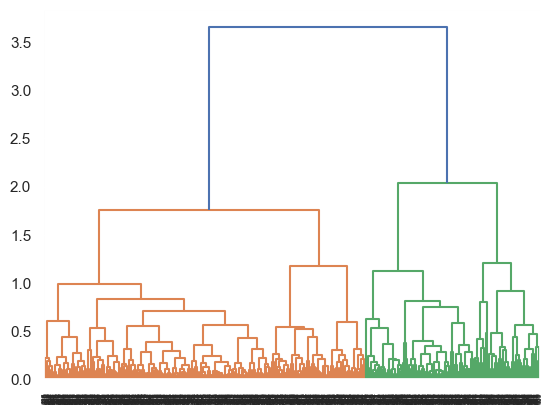

In [24]:
#dendrogram = sch.dendrogram(sch.linkage(X_principal, method='ward'))
dendrogram = sch.dendrogram(sch.linkage(clusters_found, method='ward'))


### Agglomerative Clustering

In [25]:
num_k = 5
model = AgglomerativeClustering(n_clusters=num_k, affinity='euclidean', linkage='ward')

model.fit(X_principal)
labels = model.labels_

In [26]:
pt_clusters_found = clusters_found.copy()
pt_clusters_found["cluster"] = labels

In [27]:
pt_clusters_found

,0,1,2,3,4,5,cluster
0,0.035714,0.000000,0.107143,0.071429,0.107143,0.678571,0
1,0.090909,0.000000,0.181818,0.000000,0.090909,0.636364,1
2,0.000000,0.035714,0.142857,0.035714,0.107143,0.678571,1
3,0.000000,0.000000,0.350000,0.100000,0.050000,0.500000,2
4,0.086957,0.000000,0.086957,0.130435,0.043478,0.652174,0
...,...,...,...,...,...,...,...
986,0.133333,0.000000,0.000000,0.133333,0.200000,0.533333,3
987,0.074074,0.074074,0.148148,0.037037,0.111111,0.555556,2
988,0.041667,0.020833,0.125000,0.041667,0.125000,0.645833,1
989,0.107143,0.000000,0.107143,0.035714,0.142857,0.607143,0


In [28]:
np.save("pt_clusters_labeled1029.npy", pt_clusters_found.values)
#pt_clusters_found = np.load("./var_created/pt_clusters_labeled0301.npy")

In [29]:
pt_clusters_found

,0,1,2,3,4,5,cluster
0,0.035714,0.000000,0.107143,0.071429,0.107143,0.678571,0
1,0.090909,0.000000,0.181818,0.000000,0.090909,0.636364,1
2,0.000000,0.035714,0.142857,0.035714,0.107143,0.678571,1
3,0.000000,0.000000,0.350000,0.100000,0.050000,0.500000,2
4,0.086957,0.000000,0.086957,0.130435,0.043478,0.652174,0
...,...,...,...,...,...,...,...
986,0.133333,0.000000,0.000000,0.133333,0.200000,0.533333,3
987,0.074074,0.074074,0.148148,0.037037,0.111111,0.555556,2
988,0.041667,0.020833,0.125000,0.041667,0.125000,0.645833,1
989,0.107143,0.000000,0.107143,0.035714,0.142857,0.607143,0


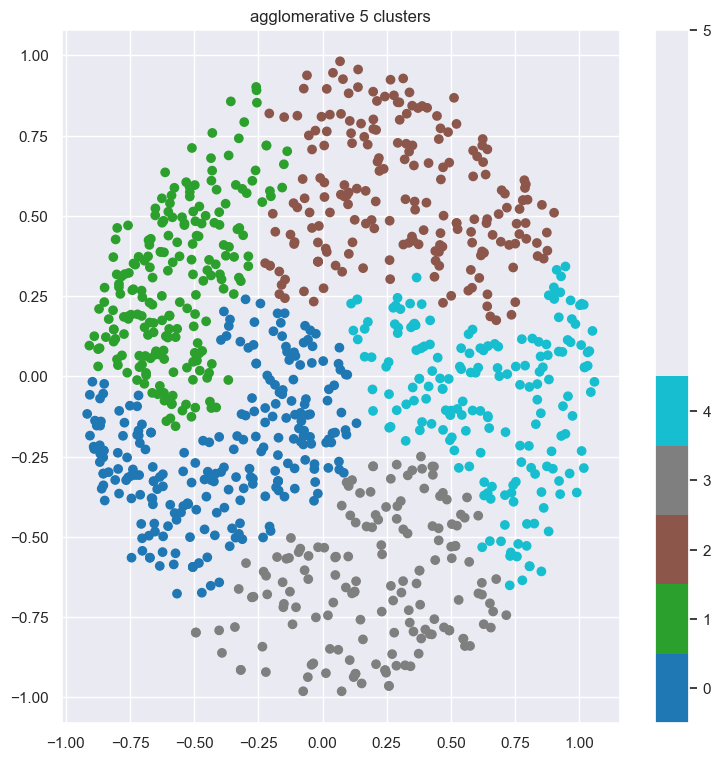

In [30]:
def graph_cluster(X_principal, labels, k, method):
    # Building the label to colour mapping
    
    plt.figure(figsize =(9, 9))
    plt.scatter(X_principal[0], X_principal[1],c=labels, cmap='tab10')
    plt.colorbar(boundaries=np.arange(k+1)-0.5).set_ticks(np.arange(k+1))
    plt.title(method + " " + str(k) + " clusters")
    #plt.legend(("0", "1"))
    plt.show()

graph_cluster(X_principal, labels, k=num_k, method= "agglomerative")

# Patient cluster visualization

In [31]:
features_df = features_df.replace("alive", 0)
features_df = features_df.replace("dead_at_discharge",1)

features_df = features_df.replace("Unknown",0)
features_df = features_df.replace("Unkown",0)
features_df = features_df.replace("No", -1)
features_df = features_df.replace("Negative", -1)
features_df = features_df.replace("Yes", 1)
features_df = features_df.replace("Positive", 1)


features_df.firstMV_fac = features_df.firstMV_fac.replace("none", -1)
features_df.firstMV_fac = features_df.firstMV_fac.replace("before 24h", 0)
features_df.firstMV_fac = features_df.firstMV_fac.replace("after 24h", 1)

clustered_features = features_df.copy()
clustered_features["Patient_Cluster"] = labels

clustered_features["Patient_Cluster"] = clustered_features["Patient_Cluster"]+1
clustered_features = clustered_features.drop("PATIENT_DEID", axis = 1)

In [32]:
clustered_features

,Death_at_discharge,Delirium_ICU,AKI,total_length_days,Mechanical_ventilation,dur_MV_days,admission_dx,first_MV,firstMV_fac,vasopressor_ICU_day,Patient_Cluster
0,0,0,-1,9.863194,-1,0.000000,Fever,0.0,-1,0.0,1
1,0,1,-1,9.857639,-1,0.000000,Pulmonary,0.0,-1,0.0,2
2,0,0,-1,8.988889,-1,0.000000,Neoplasm,0.0,-1,1.0,2
3,0,-1,-1,5.484028,-1,0.000000,Gastrointestinal,0.0,-1,0.0,3
4,0,1,-1,10.227778,-1,0.000000,Cardiovascular,0.0,-1,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
986,0,-1,-1,4.912500,-1,0.000000,Neurology,0.0,-1,0.0,4
987,0,-1,-1,9.343056,1,2.410417,Pulmonary,1.0,0,0.0,3
988,0,1,1,35.602083,1,4.352083,Trauma,1.0,0,2.0,2
989,0,1,-1,5.883333,1,0.350000,Pulmonary,1.0,0,0.0,1


In [33]:
clustered_features.to_csv("clustered_features_1029.csv")

Patient_Cluster
1    Axes(0.125,0.11;0.775x0.77)
2    Axes(0.125,0.11;0.775x0.77)
3    Axes(0.125,0.11;0.775x0.77)
4    Axes(0.125,0.11;0.775x0.77)
5    Axes(0.125,0.11;0.775x0.77)
Name: dur_MV_days, dtype: object

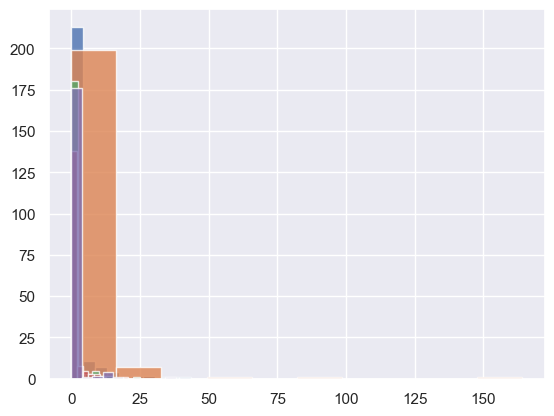

In [34]:
clustered_features.groupby(by="Patient_Cluster")["dur_MV_days"].hist(alpha = 0.8)

<Axes: title={'center': 'total_length_days'}, xlabel='[Patient_Cluster]'>

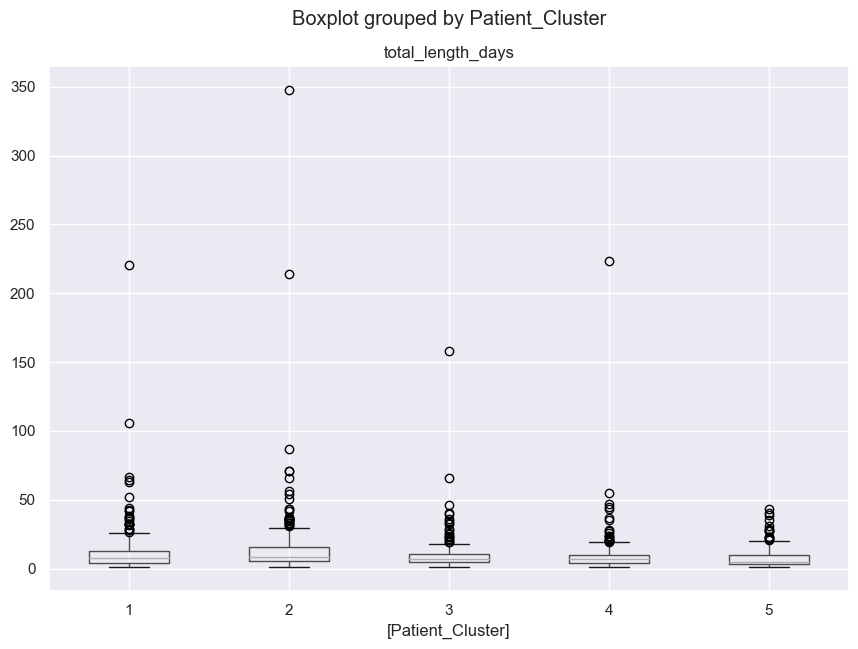

In [35]:
clustered_features[["total_length_days", "Patient_Cluster"]].boxplot(by="Patient_Cluster",  figsize=(10, 7))

<Axes: title={'center': 'vasopressor_ICU_day'}, xlabel='[Patient_Cluster]'>

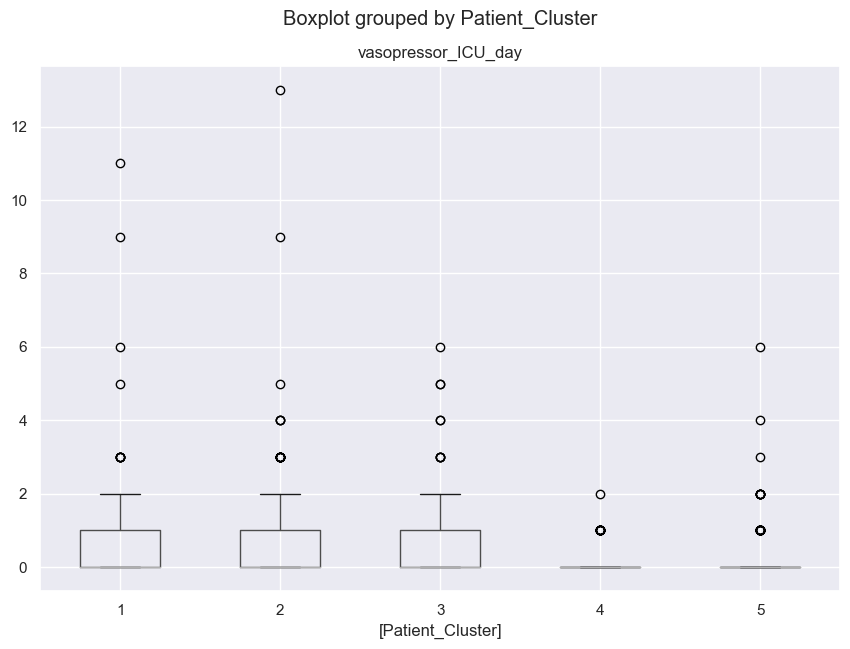

In [36]:
clustered_features[["vasopressor_ICU_day", "Patient_Cluster"]].boxplot(by="Patient_Cluster",  figsize=(10, 7))

In [37]:
morph_data = clustered_features.copy()
morph_data = morph_data.replace("Negative", 0)
morph_data = morph_data.replace("No", 0)
morph_data = morph_data.replace("none", 0)
morph_data = morph_data.replace("Unknown", 0)
morph_data = morph_data.replace("alive", 0)

morph_data = morph_data.replace("Positive", 1)
morph_data = morph_data.replace("Yes", 1)
morph_data = morph_data.replace("before 24h", 1)
morph_data = morph_data.replace("after 24h", 2)
morph_data = morph_data.replace("dead_at_discharge", 1)

In [235]:
morph_data.groupby(by="Patient_Cluster").describe().to_csv("patient-cluster_analysis_1029.csv", index= True)

In [38]:
dfp = clustered_features.pivot_table(index='Patient_Cluster', columns='Death_at_discharge', aggfunc='size')


<Axes: xlabel='Patient_Cluster'>

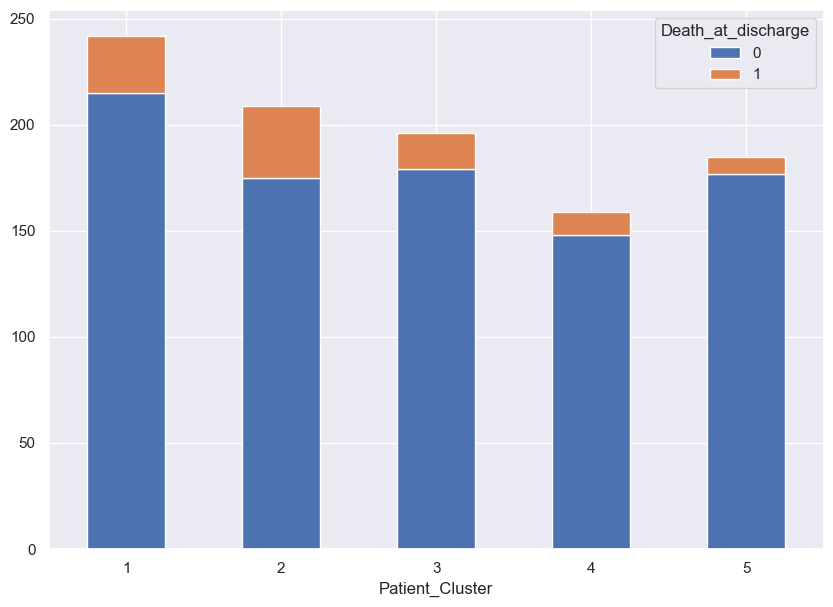

In [39]:
dfp.plot(kind='bar', figsize=(10, 7), rot=0, stacked=True)

# Cluster Morphology

In [81]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num=n_ordinate_levels)
            
            # Create labels for all grid lines but make them empty strings by default
            grid_label = [""] * len(grid)  
            
            # Update only the labels you want to display
            for j, x in enumerate(grid[1:-1], start=1):  
                grid_label[j] = "{:.02f}".format(x)
            
            ax.set_rgrids(grid, labels=grid_label, angle=angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

In [82]:
merged = morph_data.groupby("Patient_Cluster").mean()

In [83]:
merged

,Death_at_discharge,Delirium_ICU,AKI,total_length_days,Mechanical_ventilation,dur_MV_days,first_MV,firstMV_fac,vasopressor_ICU_day
Patient_Cluster,,,,,,,,,
1,0.111570,-0.136364,-0.756198,12.145236,-0.322314,2.112474,0.450413,-0.628099,0.516529
2,0.162679,-0.028708,-0.473684,15.912789,-0.186603,3.621604,0.478469,-0.559809,0.765550
3,0.086735,-0.566327,-0.566327,10.105722,-0.367347,0.904829,0.418367,-0.647959,0.581633
4,0.069182,-0.339623,-0.849057,10.503201,-0.446541,0.953114,0.314465,-0.704403,0.132075
5,0.043243,-0.632432,-0.827027,7.761194,-0.578378,0.873863,0.291892,-0.745946,0.302703


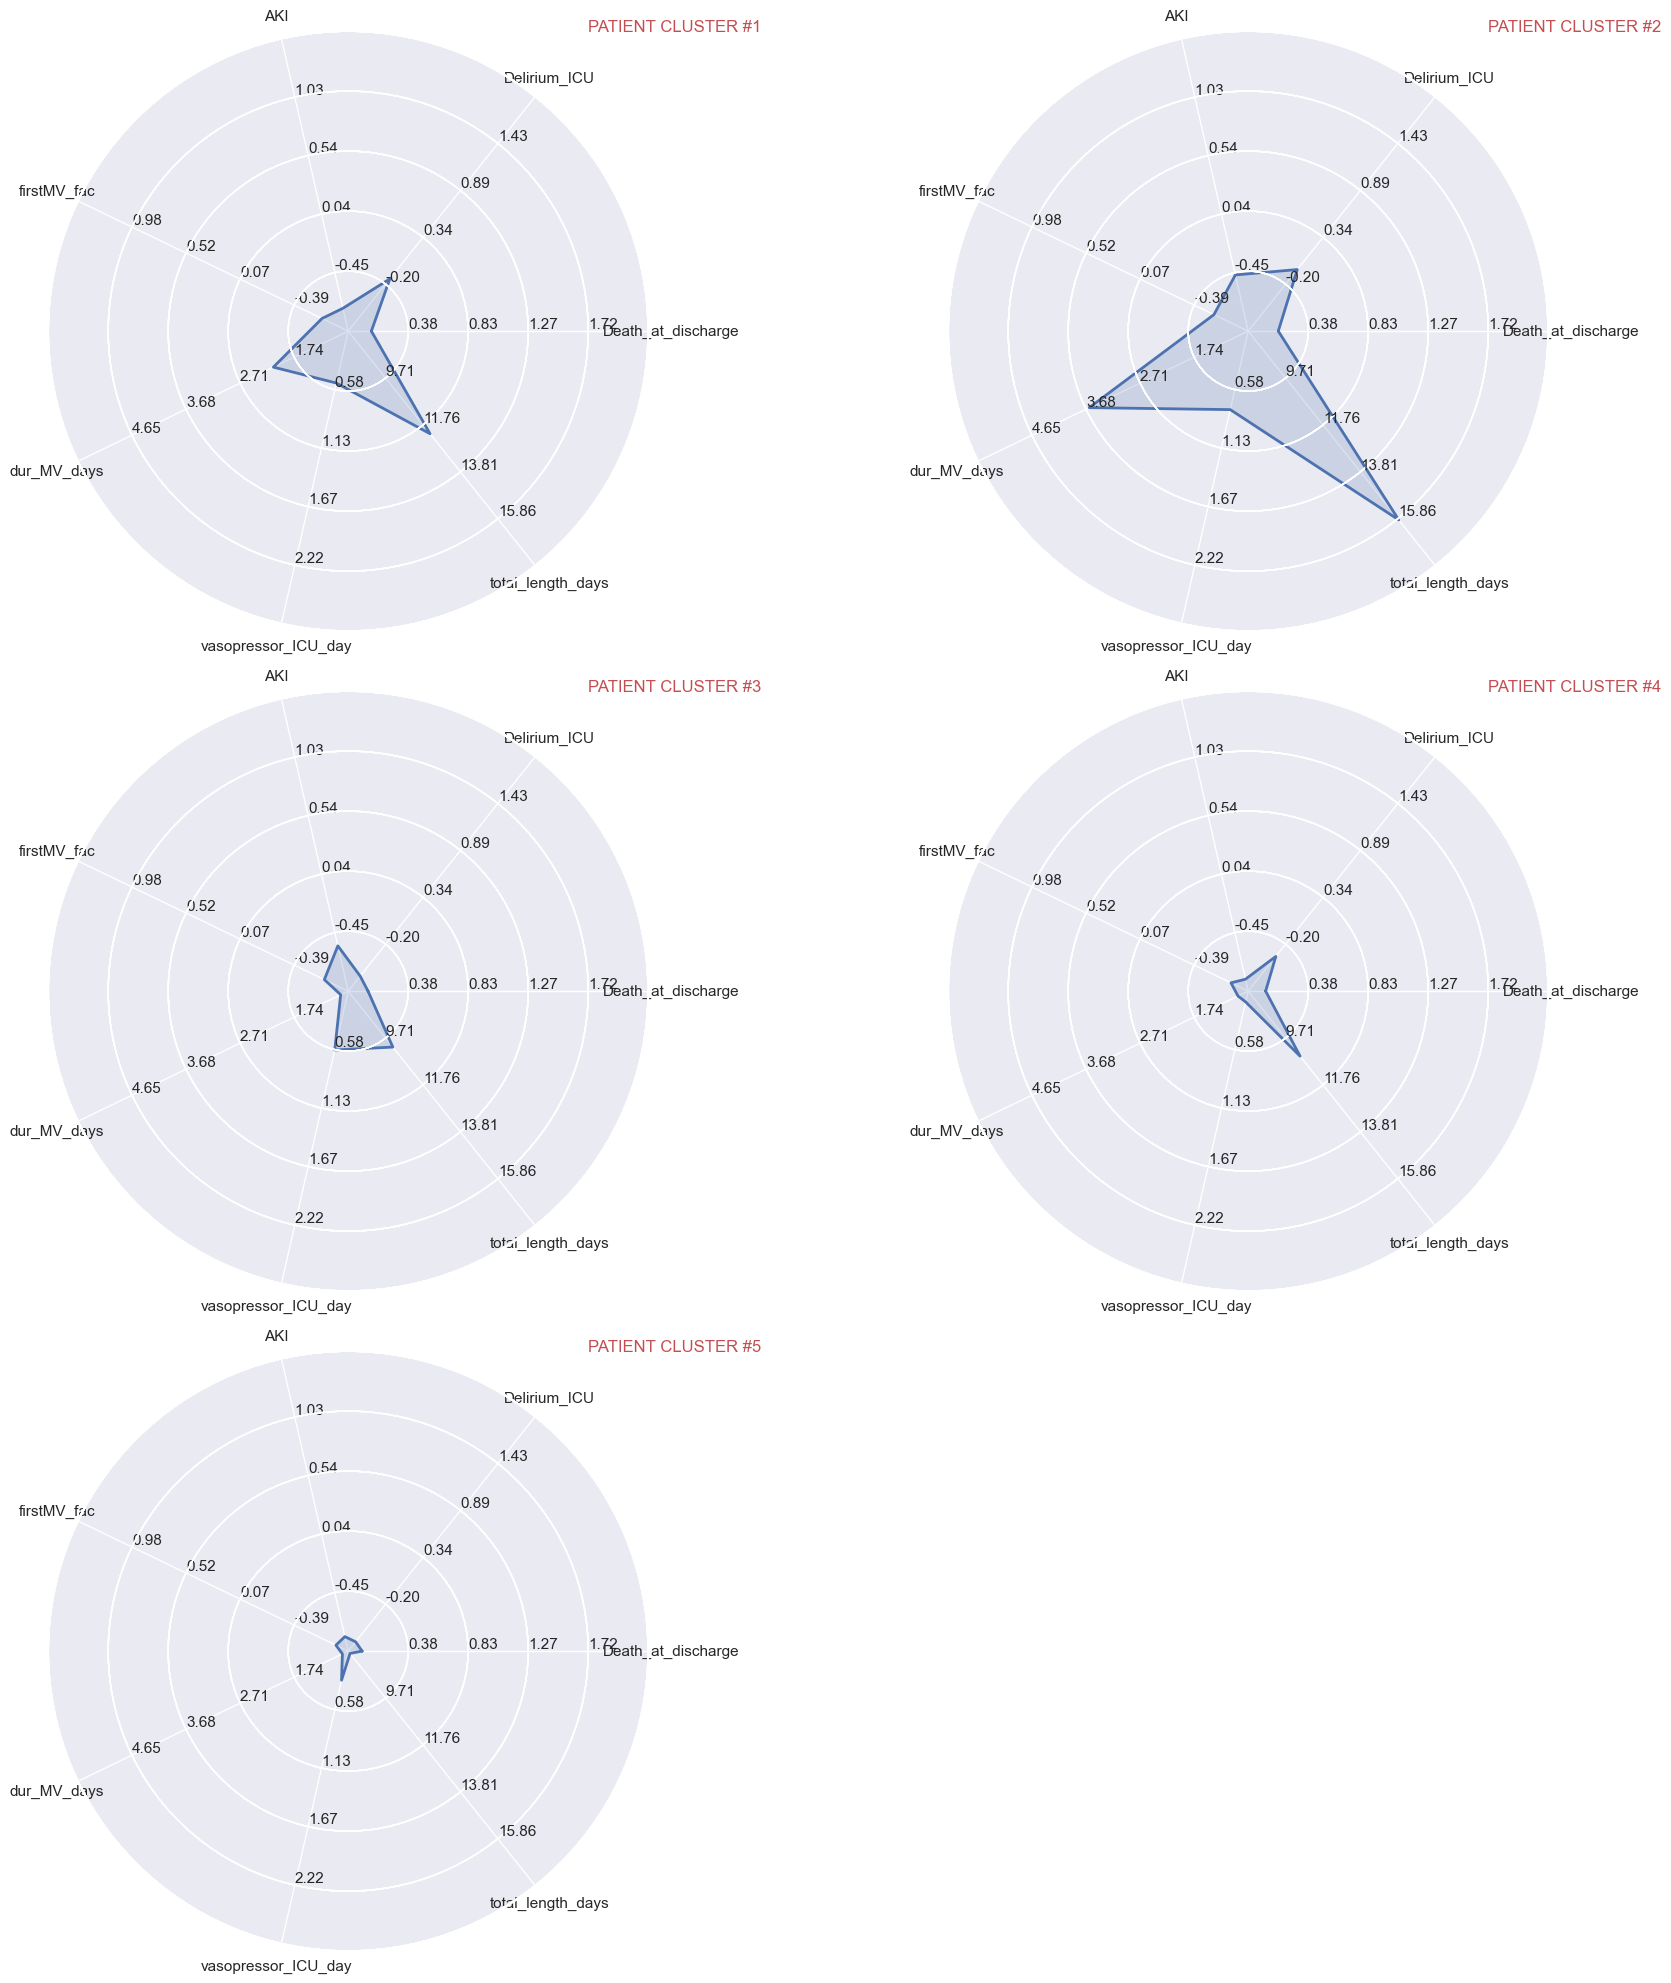

In [84]:
fig = plt.figure(figsize=(15,12))

attributes = ["Death_at_discharge", 'Delirium_ICU', "AKI", 'firstMV_fac', 'dur_MV_days', 'vasopressor_ICU_day', "total_length_days"]
ranges = [[merged[at].min() // 0.01 / 100 - 0.1, round(merged[at].max(), 2)+2] for at in attributes]
index  = [0, 1, 2, 3, 4, 5]
n_clusters = 5
n_groups = n_clusters ; i_cols = 2

i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%2 ; iy = i_rows - ind//2
    pos_x = ix*(size_x + 0.1) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged.loc[ind+1, attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'PATIENT CLUSTER #{}'.format(index[ind]+1), color = 'r')
    ind += 1 